# Import Libraries

In [1]:
!pip install imblearn

In [2]:
!pip install pyclustering

In [3]:
import pandas as pd
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from scipy.sparse import csr_matrix

C:\Users\Asty\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Asty\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\Asty\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Read Data

In [4]:
df = pd.read_csv('Tweets.csv')

In [5]:
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


# Preprocessing

## Select only text and airline_sentiment

In [6]:
df = df[['text','airline_sentiment']]

In [7]:
df.tail()

,text,airline_sentiment
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative
14639,@AmericanAir we have 8 ppl so we need 2 know h...,neutral


## Printing all text to observe data
**Currently set to be a comment 

In [8]:
# for text in df['text']:
#     print(text)

## Transform into Lowercase

In [9]:
df['text'] = df['text'].str.lower()
df['text']

0                      @virginamerica what @dhepburn said.
1        @virginamerica plus you've added commercials t...
2        @virginamerica i didn't today... must mean i n...
3        @virginamerica it's really aggressive to blast...
4        @virginamerica and it's a really big bad thing...
                               ...                        
14635    @americanair thank you we got on a different f...
14636    @americanair leaving over 20 minutes late flig...
14637    @americanair please bring american airlines to...
14638    @americanair you have my money, you change my ...
14639    @americanair we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

## Convert emoji to text using demoji

In [10]:
# !pip install demoji
# import demoji

# demoji.download_codes()

In [11]:
# df['text'][0]

In [12]:
# def replace_emojis(text):
#     emojis = demoji.findall(text)
#     for emoji, description in emojis.items():
#         text = text.replace(emoji, f' {description} ')

#     return text

In [13]:
# replace_emojis(df['text'][18])

In [14]:
# df['text'] = df['text'].apply(replace_emojis)

## Removing links

In [15]:
def remove_links(text):
    return re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

df['text'] = df['text'].apply(remove_links)

## Treating stopwords

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
df

,text,airline_sentiment
0,@virginamerica what @dhepburn said.,neutral
1,@virginamerica plus you've added commercials t...,positive
2,@virginamerica i didn't today... must mean i n...,neutral
3,@virginamerica it's really aggressive to blast...,negative
4,@virginamerica and it's a really big bad thing...,negative
...,...,...
14635,@americanair thank you we got on a different f...,positive
14636,@americanair leaving over 20 minutes late flig...,negative
14637,@americanair please bring american airlines to...,neutral
14638,"@americanair you have my money, you change my ...",negative


In [18]:
df['text'] = [nltk.tokenize.word_tokenize(docs) for docs in df['text']]
df

,text,airline_sentiment
0,"[@, virginamerica, what, @, dhepburn, said, .]",neutral
1,"[@, virginamerica, plus, you, 've, added, comm...",positive
2,"[@, virginamerica, i, did, n't, today, ..., mu...",neutral
3,"[@, virginamerica, it, 's, really, aggressive,...",negative
4,"[@, virginamerica, and, it, 's, a, really, big...",negative
...,...,...
14635,"[@, americanair, thank, you, we, got, on, a, d...",positive
14636,"[@, americanair, leaving, over, 20, minutes, l...",negative
14637,"[@, americanair, please, bring, american, airl...",neutral
14638,"[@, americanair, you, have, my, money, ,, you,...",negative


In [19]:
df['text'][1]

['@',
 'virginamerica',
 'plus',
 'you',
 "'ve",
 'added',
 'commercials',
 'to',
 'the',
 'experience',
 '...',
 'tacky',
 '.']

In [20]:
nltk.download('stopwords')
all_stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Exclude some words from stopwords. This is a sentiment analysis case. We may need some of these exceptions.

In [21]:
exclude_from_stop = {"not", "no", "never", "none", "isn't", "aren't", "wasn't", "weren't", "doesn't", "don't",
                     "didn't", "won't", "wouldn't", "can't", "couldn't", "shouldn't", "haven't", "hasn't",
                     "hadn't", "mightn't", "mustn't", "but", "if", "because", "as", "though", "although",
                     "until", "while", "against", "under", "over", "into", "through", "before", "after",
                     "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under",
                     "more", "most", "less", "least", "few", "fewer", "many", "several", "enough", "never",
                     "needn't","shan't",'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn',
                     'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn','don',"n't"}
stopwrds = [word for word in all_stopwords if word not in exclude_from_stop]

additional_stopwords = ["'re", "'s","'ve","'m","'d","'tis","y'all"]
stopwrds.extend(additional_stopwords)

print(stopwrds)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'or', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'during', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ma', "'re", "'s", "'ve", "'m", "'d", "'tis", "y'all"]


Finally, remove the stopwords

In [22]:
def remove_stopwords(text):
    return ' '.join([word for word in text if word not in stopwrds])

df['text'] = df['text'].apply(remove_stopwords)
df

,text,airline_sentiment
0,@ virginamerica @ dhepburn said .,neutral
1,@ virginamerica plus added commercials to expe...,positive
2,@ virginamerica n't today ... must mean need t...,neutral
3,@ virginamerica really aggressive to blast obn...,negative
4,@ virginamerica really big bad thing,negative
...,...,...
14635,@ americanair thank got on different flight to...,positive
14636,@ americanair leaving over 20 minutes late fli...,negative
14637,@ americanair please bring american airlines t...,neutral
14638,"@ americanair money , change flight , n't answ...",negative


## Removing Punctuations

In [23]:
def remove_punctuation(text):
    whitelist = 'a-zA-Z '
    pattern = f"[^{whitelist}]"
    return re.sub(pattern, '', text)

df['text'] = df['text'].apply(remove_punctuation)
df

,text,airline_sentiment
0,virginamerica dhepburn said,neutral
1,virginamerica plus added commercials to exper...,positive
2,virginamerica nt today must mean need to tak...,neutral
3,virginamerica really aggressive to blast obno...,negative
4,virginamerica really big bad thing,negative
...,...,...
14635,americanair thank got on different flight to ...,positive
14636,americanair leaving over minutes late flight...,negative
14637,americanair please bring american airlines to...,neutral
14638,americanair money change flight nt answer p...,negative


## Lemmatization

In [24]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asty\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    words = sentence.split()
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = []
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        if wordnet_tag is not None:
            lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_tag)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
    return ' '.join(lemmatized_words)

df['text'] = df['text'].apply(lemmatize_sentence)

## Manual Checking
**Currently set to be a comment 

In [26]:
# for text in df['text']:
#     print(text)

# EDA

In [27]:
df.tail()

,text,airline_sentiment
14635,americanair thank get on different flight to c...,positive
14636,americanair leave over minute late flight no w...,negative
14637,americanair please bring american airline to b...,neutral
14638,americanair money change flight nt answer phon...,negative
14639,americanair ppl need know many seat on next fl...,neutral


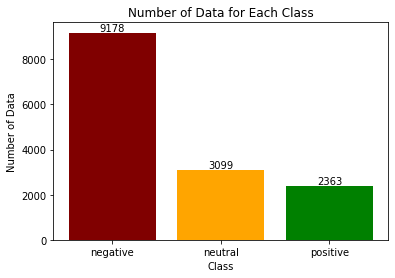

In [28]:
colors = ['maroon', 'orange', 'green']
class_counts = df['airline_sentiment'].value_counts()

fig, ax = plt.subplots()
bars = ax.bar(class_counts.index, class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

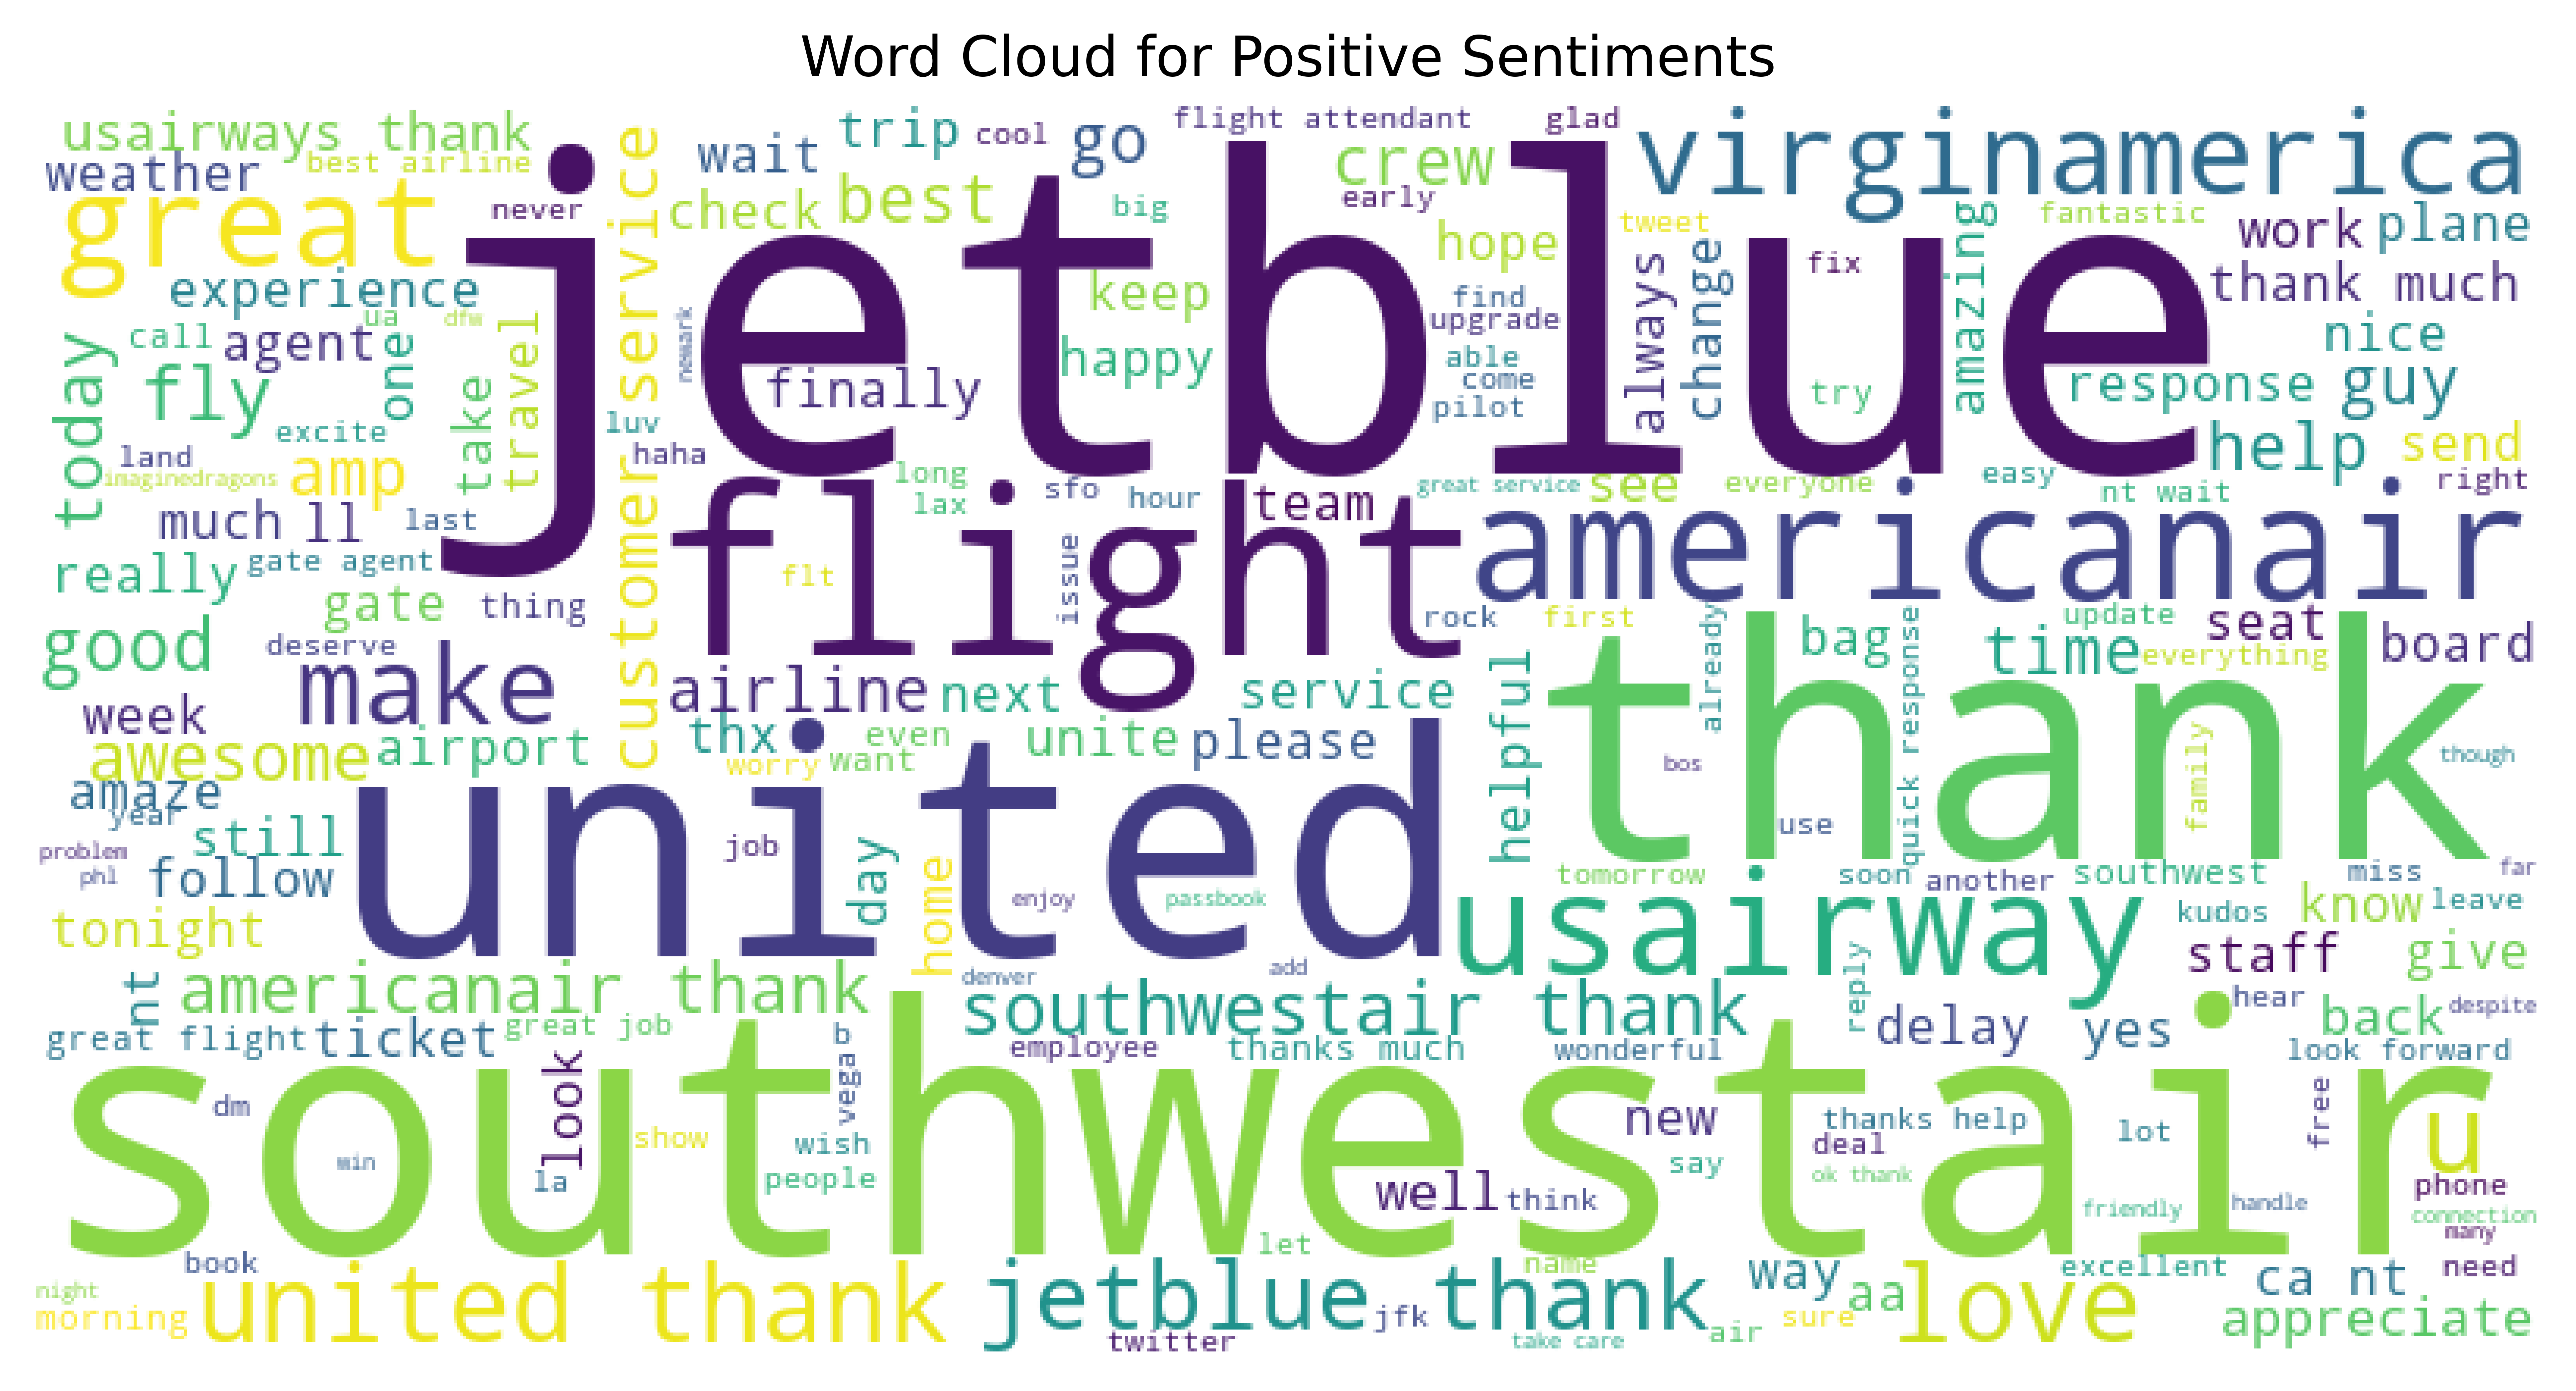

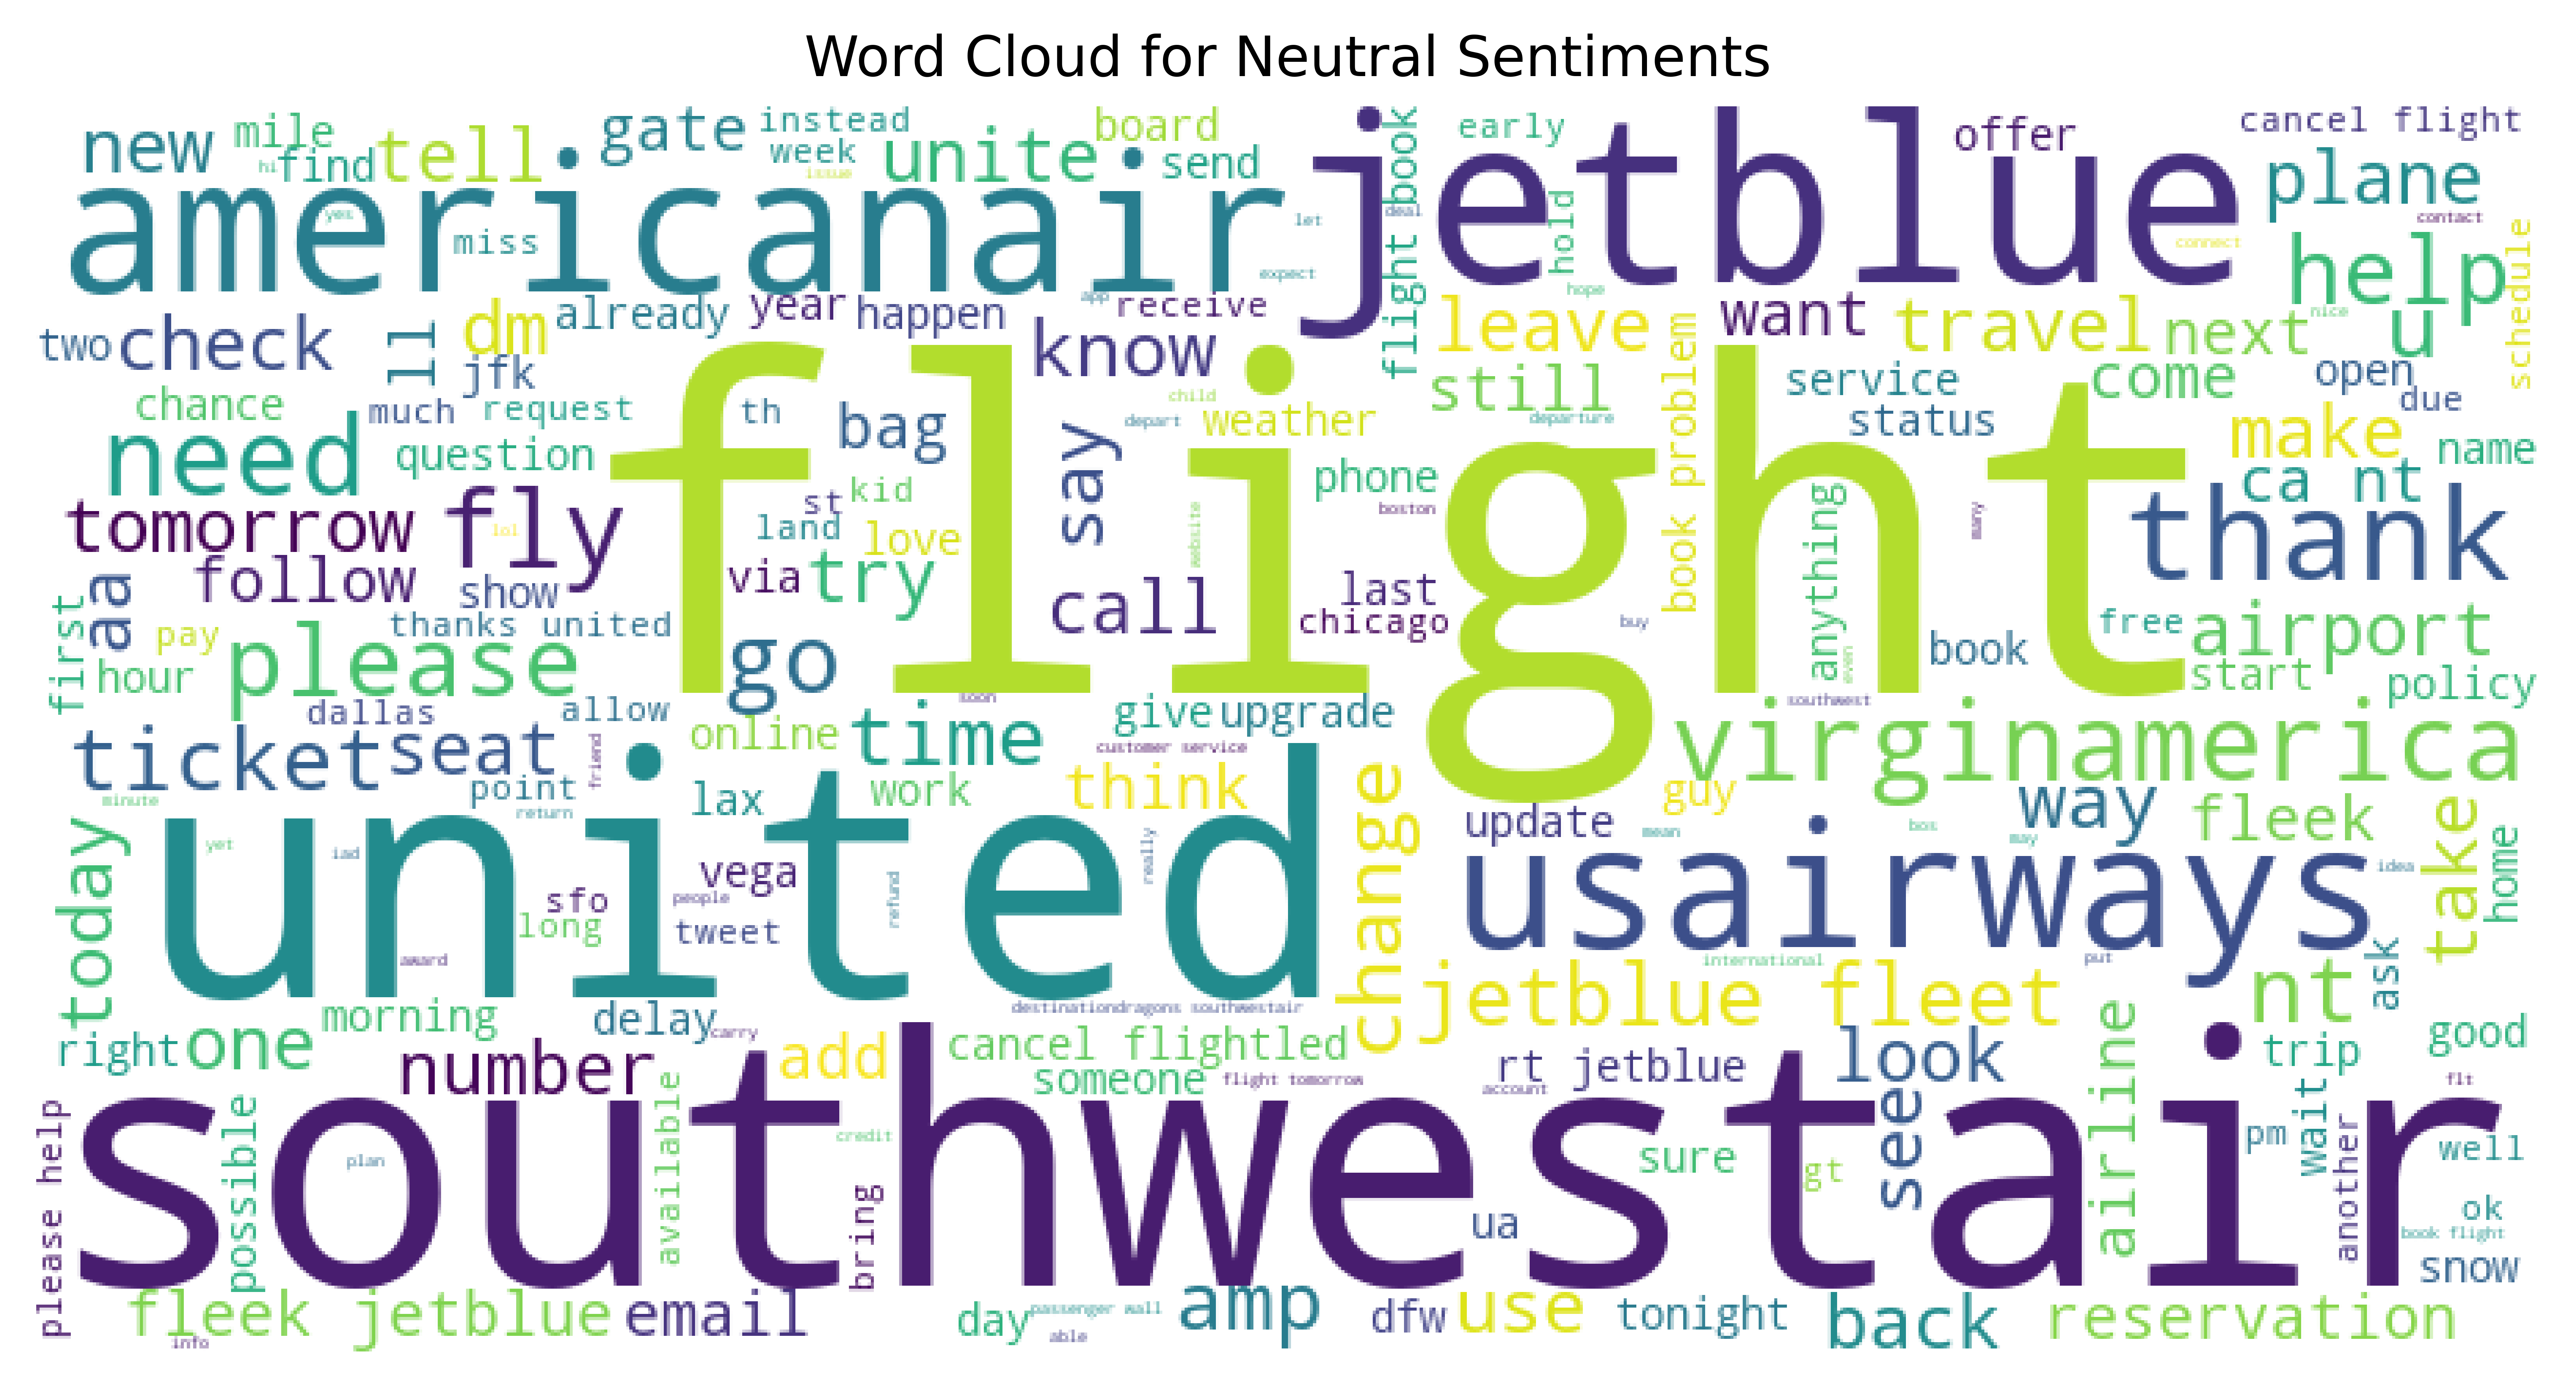

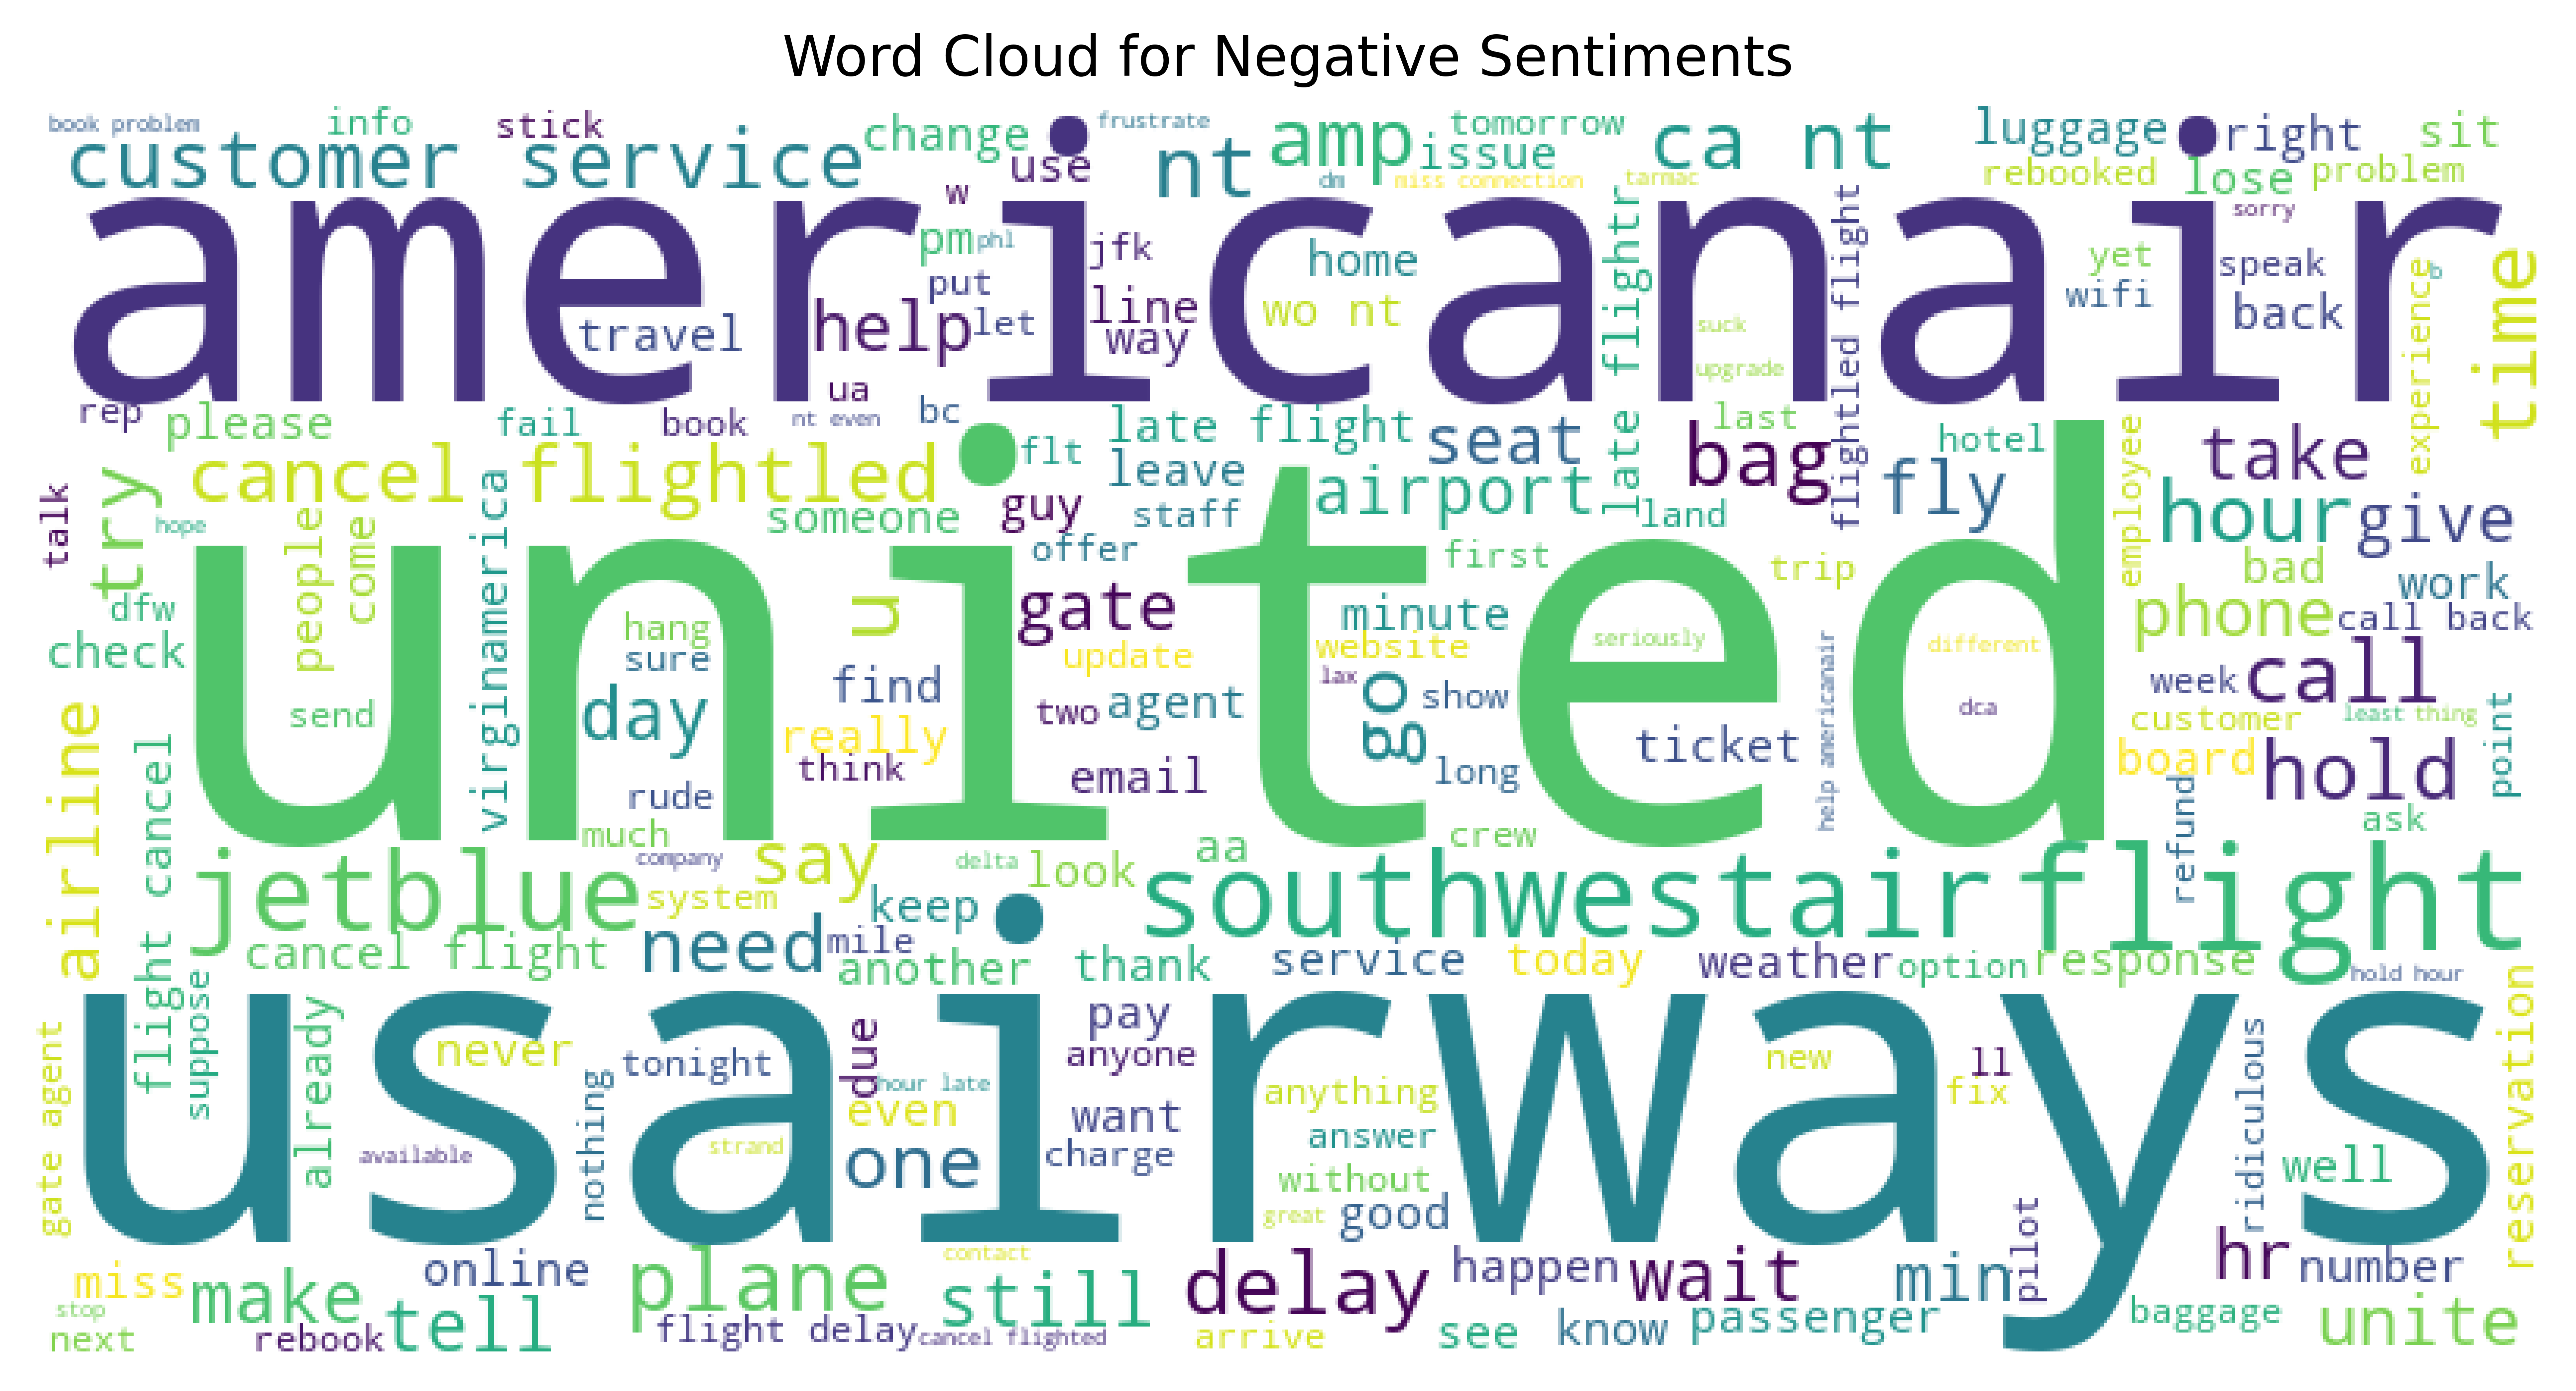

In [29]:
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(data))
    plt.figure(figsize=(10, 5), dpi=1000)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds for each label
for label in ['positive', 'neutral', 'negative']:
    subset = df[df['airline_sentiment'] == label]['text']
    generate_wordcloud(subset, f'Word Cloud for {label.capitalize()} Sentiments')

## Map label into integers

In [30]:
df['airline_sentiment'] = df['airline_sentiment'].replace({'positive': 2, 'neutral': 1, 'negative':0})

C:\Users\Asty\AppData\Local\Temp\ipykernel_146728\1813139062.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['airline_sentiment'] = df['airline_sentiment'].replace({'positive': 2, 'neutral': 1, 'negative':0})


# Data Splitting

In [44]:
RANDOM_SEED = 42
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)

# Applying TFIDF

In [45]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_test_tfidf = tfidf.transform(df_test['text'])

In [46]:
X_train_tfidf

<10248x9118 sparse matrix of type '<class 'numpy.float64'>'
	with 112918 stored elements in Compressed Sparse Row format>

In [47]:
X_test_tfidf

<4392x9118 sparse matrix of type '<class 'numpy.float64'>'
	with 46787 stored elements in Compressed Sparse Row format>

In [48]:
y_train = df_train['airline_sentiment']
y_test = df_test['airline_sentiment']

# Show data in training

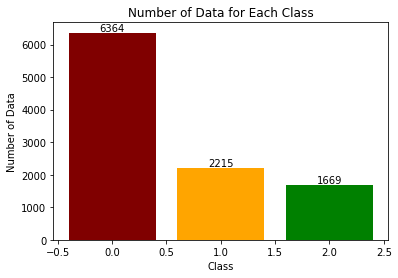

In [49]:
colors = ['maroon', 'orange', 'green']
class_counts = y_train.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(class_counts.index, class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

# Show data in testing

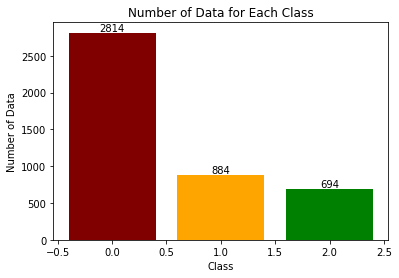

In [50]:
colors = ['maroon', 'orange', 'green']
class_counts = y_test.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(class_counts.index, class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

# First Experiment: Using XGBoost

In [51]:
#Params from auto tuning
xgbparams = {'colsample_bytree': 0.15, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5}

In [52]:
# param_grid = {'min_child_weight': [1, 5, 10],
#               'gamma': [0, 0.5, 1, 1.5],
#               'subsample': [0.3, 0.4, 0.5],
#               'colsample_bytree': [0.05, 0.1, 0.15],
#               'max_depth': [3, 5, 7]}

# # clf = xgb.XGBClassifier()
# # clf.fit(X_train_tfidf, y_train)
# grid = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=10, refit=True)
# grid.fit(X_train_tfidf, y_train)
# y_pred = grid.predict(X_test_tfidf)
# xgbparams = grid.best_params_
# print(xgbparams)

In [53]:
clf = xgb.XGBClassifier(**xgbparams)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [54]:
accuracy_xgb_base = accuracy_score(y_test, y_pred)
precision_xgb_base = precision_score(y_test, y_pred, average='macro')
recall_xgb_base = recall_score(y_test, y_pred, average='macro')
f1_xgb_base = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_xgb_base)
print('Precision: ', precision_xgb_base)
print('Recall: ', recall_xgb_base)
print('F1 score: ', f1_xgb_base)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7891621129326047
Precision:  0.7439071748667397
Recall:  0.6875068580973706
F1 score:  0.7109126708721764
Confusion Matrix:
 [[2566  187   61]
 [ 348  472   64]
 [ 171   95  428]]


# Second Experiment: Base using SVM

In [55]:
#Params from auto tuning
svmparams = {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

In [56]:
# # clf = SVC()
# # clf.fit(X_train_tfidf, y_train)
# # y_pred = text_clf.predict(X_test)

# param_grid = {'C': [0.01,0.1,1,10,100],
#               'gamma': ['scale','auto'],
#               'kernel': ['rbf','linear','poly','sigmoid']}

# grid = GridSearchCV(SVC(), param_grid, cv=10, refit=True)

# grid.fit(X_train_tfidf, y_train)
# y_pred = grid.predict(X_test_tfidf)

# svmparams = grid.best_params_
# print(svmparams)

In [57]:
clf = SVC(**svmparams)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [59]:
accuracy_svm_base = accuracy_score(y_test, y_pred)
precision_svm_base = precision_score(y_test, y_pred, average='macro')
recall_svm_base = recall_score(y_test, y_pred, average='macro')
f1_svm_base = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_svm_base)
print('Precision: ', precision_svm_base)
print('Recall: ', recall_svm_base)
print('F1 score: ', f1_svm_base)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.8044171220400729
Precision:  0.7611547559041262
Recall:  0.7074877173192596
F1 score:  0.7300172431886794
Confusion Matrix:
 [[2600  162   52]
 [ 343  471   70]
 [ 139   93  462]]


# Oversampling

## SMOTE

In [60]:
smt = SMOTE()
X_train_tfidf_sm, y_train_sm = smt.fit_resample(X_train_tfidf, y_train)
X_train_tfidf_sm

<19092x9118 sparse matrix of type '<class 'numpy.float64'>'
	with 226461 stored elements in Compressed Sparse Row format>

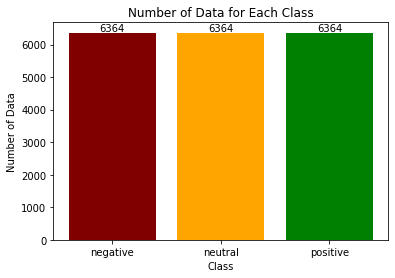

In [61]:
colors = ['maroon', 'orange', 'green']
class_counts = y_train_sm.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(['negative', 'neutral', 'positive'], class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

## ADASYN

In [62]:
ada = ADASYN()
X_train_tfidf_ada, y_train_ada = ada.fit_resample(X_train_tfidf, y_train)
X_train_tfidf_ada

<19092x9118 sparse matrix of type '<class 'numpy.float64'>'
	with 236454 stored elements in Compressed Sparse Row format>

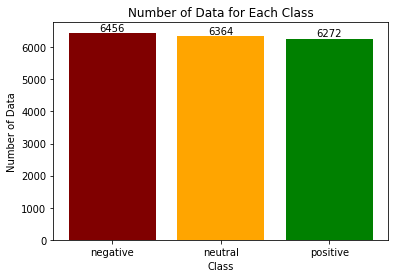

In [63]:
colors = ['maroon', 'orange', 'green']
class_counts = y_train_ada.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(['negative', 'neutral', 'positive'], class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

## XGBoost with SMOTE

In [64]:
clf = xgb.XGBClassifier(**xgbparams)
clf.fit(X_train_tfidf_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.15, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [65]:
y_pred = clf.predict(X_test_tfidf)

In [66]:
accuracy_xgb_sm = accuracy_score(y_test, y_pred)
precision_xgb_sm = precision_score(y_test, y_pred, average='macro')
recall_xgb_sm = recall_score(y_test, y_pred, average='macro')
f1_xgb_sm = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_xgb_sm)
print('Precision: ', precision_xgb_sm)
print('Recall: ', recall_xgb_sm)
print('F1 score: ', f1_xgb_sm)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7784608378870674
Precision:  0.7205806164341801
Recall:  0.7046414603608714
F1 score:  0.71142739985995
Confusion Matrix:
 [[2440  297   77]
 [ 274  529   81]
 [ 133  111  450]]


## XGBoost with ADASYN

In [67]:
clf = xgb.XGBClassifier(**xgbparams)
clf.fit(X_train_tfidf_ada, y_train_ada)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.15, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [68]:
y_pred = clf.predict(X_test_tfidf)

In [69]:
accuracy_xgb_ada = accuracy_score(y_test, y_pred)
precision_xgb_ada = precision_score(y_test, y_pred, average='macro')
recall_xgb_ada = recall_score(y_test, y_pred, average='macro')
f1_xgb_ada = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_xgb_ada)
print('Precision: ', precision_xgb_ada)
print('Recall: ', recall_xgb_ada)
print('F1 score: ', f1_xgb_ada)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7807377049180327
Precision:  0.7228765105418932
Recall:  0.7040167535122409
F1 score:  0.712171227376226
Confusion Matrix:
 [[2455  277   82]
 [ 280  529   75]
 [ 132  117  445]]


## SVM with SMOTE

In [70]:
clf = SVC(**svmparams)
clf.fit(X_train_tfidf_sm, y_train_sm)

SVC(C=100)

In [71]:
y_pred = clf.predict(X_test_tfidf)

In [72]:
accuracy_svm_sm = accuracy_score(y_test, y_pred)
precision_svm_sm = precision_score(y_test, y_pred, average='macro')
recall_svm_sm = recall_score(y_test, y_pred, average='macro')
f1_svm_sm = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_svm_sm)
print('Precision: ', precision_svm_sm)
print('Recall: ', recall_svm_sm)
print('F1 score: ', f1_svm_sm)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7982695810564663
Precision:  0.7573972532338272
Recall:  0.6908998273864061
F1 score:  0.7177318698824076
Confusion Matrix:
 [[2612  155   47]
 [ 359  464   61]
 [ 155  109  430]]


## SVM with ADASYN

In [73]:
clf = SVC(**svmparams)
clf.fit(X_train_tfidf_ada, y_train_ada)

SVC(C=100)

In [74]:
y_pred = clf.predict(X_test_tfidf)

In [75]:
accuracy_svm_ada = accuracy_score(y_test, y_pred)
precision_svm_ada = precision_score(y_test, y_pred, average='macro')
recall_svm_ada = recall_score(y_test, y_pred, average='macro')
f1_svm_ada = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_svm_ada)
print('Precision: ', precision_svm_ada)
print('Recall: ', recall_svm_ada)
print('F1 score: ', f1_svm_ada)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7966757741347905
Precision:  0.7546481762245589
Recall:  0.6860381158080237
F1 score:  0.713416953780054
Confusion Matrix:
 [[2617  152   45]
 [ 362  461   61]
 [ 154  119  421]]


# Undersampling

## TomekLinks

In [76]:
tomek = TomekLinks()
X_train_tfidf_tm, y_train_tm = tomek.fit_resample(X_train_tfidf, y_train)
X_train_tfidf_tm

<9693x9118 sparse matrix of type '<class 'numpy.float64'>'
	with 108037 stored elements in Compressed Sparse Row format>

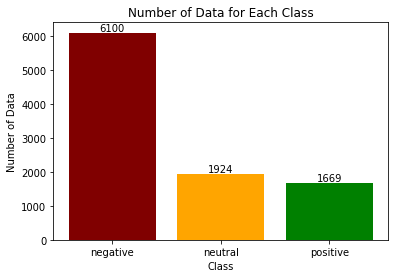

In [77]:
colors = ['maroon', 'orange', 'green']
class_counts = y_train_tm.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(['negative', 'neutral', 'positive'], class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

## Clustering Based

In [78]:
from sklearn.metrics import silhouette_score

max_clusters = 150
# Filter only the majority class samples
X_majority = X_train_tfidf[y_train == 0]

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_majority)  # Cluster only majority class samples
    silhouette_avg = silhouette_score(X_majority, cluster_labels)
    silhouette_scores.append(silhouette_avg)

Optimal number of clusters based on silhouette score: 54


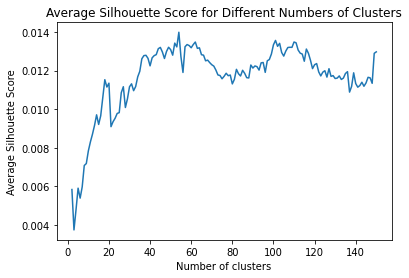

In [79]:
# # Find the optimal number of clusters

# optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 to start counting from 2 clusters

# print("Optimal number of clusters based on silhouette score:", optimal_num_clusters)


# plt.plot(range(2, max_clusters + 1), silhouette_scores)
# plt.xlabel('Number of clusters')
# plt.ylabel('Average Silhouette Score')
# plt.title('Average Silhouette Score for Different Numbers of Clusters')
# plt.show()


In [94]:
optimal_num_clusters = 66

In [95]:
from imblearn.under_sampling import ClusterCentroids
y_train_str = y_train.astype(str)
undersampler = ClusterCentroids(sampling_strategy='majority',estimator=KMeans(n_clusters=optimal_num_clusters))
X_train_tfidf_cc, y_train_cc_str = undersampler.fit_resample(X_train_tfidf, y_train_str)
y_train_cc = y_train_cc_str.astype(int)

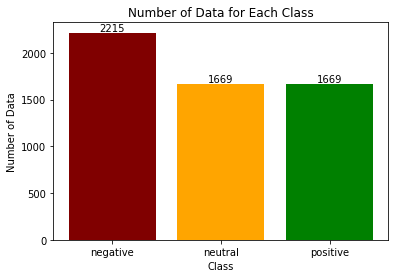

In [96]:
colors = ['maroon', 'orange', 'green']
class_counts = y_train_cc.value_counts()

fig, ax = plt.subplots()
bars = ax.bar(['negative', 'neutral', 'positive'], class_counts.values,color=colors)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Number of Data')
ax.set_title('Number of Data for Each Class')

# Show the plot
plt.show()

## XGBoost with TomekLinks

In [97]:
clf = xgb.XGBClassifier(**xgbparams)
clf.fit(X_train_tfidf_tm, y_train_tm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.15, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [98]:
y_pred = clf.predict(X_test_tfidf)

In [99]:
accuracy_xgb_tm = accuracy_score(y_test, y_pred)
precision_xgb_tm = precision_score(y_test, y_pred, average='macro')
recall_xgb_tm = recall_score(y_test, y_pred, average='macro')
f1_xgb_tm = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_xgb_tm)
print('Precision: ', precision_xgb_tm)
print('Recall: ', recall_xgb_tm)
print('F1 score: ', f1_xgb_tm)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7914389799635702
Precision:  0.7448993024855094
Recall:  0.6853261611556086
F1 score:  0.7091610161956344
Confusion Matrix:
 [[2595  152   67]
 [ 371  438   75]
 [ 166   85  443]]


## XGBoost with ClusterCentroids

In [100]:
clf = xgb.XGBClassifier(**xgbparams)
clf.fit(X_train_tfidf_cc, y_train_cc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.15, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [101]:
y_pred = clf.predict(X_test_tfidf)

In [102]:
accuracy_xgb_cc = accuracy_score(y_test, y_pred)
precision_xgb_cc = precision_score(y_test, y_pred, average='macro')
recall_xgb_cc = recall_score(y_test, y_pred, average='macro')
f1_xgb_cc = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_xgb_cc)
print('Precision: ', precision_xgb_cc)
print('Recall: ', recall_xgb_cc)
print('F1 score: ', f1_xgb_cc)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7015027322404371
Precision:  0.6593393389847709
Recall:  0.7116124940035139
F1 score:  0.6658007631999711
Confusion Matrix:
 [[1935  688  191]
 [ 117  659  108]
 [  52  155  487]]


## SVM with TomekLinks

In [88]:
clf = SVC(**svmparams)
clf.fit(X_train_tfidf_tm, y_train_tm)

SVC(C=100)

In [89]:
y_pred = clf.predict(X_test_tfidf)

In [90]:
accuracy_svm_tm = accuracy_score(y_test, y_pred)
precision_svm_tm = precision_score(y_test, y_pred, average='macro')
recall_svm_tm = recall_score(y_test, y_pred, average='macro')
f1_svm_tm = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_svm_tm)
print('Precision: ', precision_svm_tm)
print('Recall: ', recall_svm_tm)
print('F1 score: ', f1_svm_tm)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.799408014571949
Precision:  0.7556426034874605
Recall:  0.695414976727519
F1 score:  0.7188529737966521
Confusion Matrix:
 [[2617  140   57]
 [ 378  426   80]
 [ 147   79  468]]


## SVM with ClusterCentroids

In [91]:
clf = SVC(**svmparams)
clf.fit(X_train_tfidf_cc, y_train_cc)

SVC(C=100)

In [92]:
y_pred = clf.predict(X_test_tfidf)

In [93]:
accuracy_svm_cc = accuracy_score(y_test, y_pred)
precision_svm_cc = precision_score(y_test, y_pred, average='macro')
recall_svm_cc = recall_score(y_test, y_pred, average='macro')
f1_svm_cc = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', accuracy_svm_cc)
print('Precision: ', precision_svm_cc)
print('Recall: ', recall_svm_cc)
print('F1 score: ', f1_svm_cc)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.7383879781420765
Precision:  0.6927238306969602
Recall:  0.7364354375813439
F1 score:  0.701682153709815
Confusion Matrix:
 [[2084  598  132]
 [ 139  650   95]
 [  54  131  509]]
